In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

# === Load Data ===
df = pd.read_csv(r'C:\Users\akhil\OneDrive\Documents\point2building\train.csv')
feature_cols = ['distance', 'planarity_v1', 'height_diff', 'normal_similarity', 'curvature_v2', 'planarity_v2', 'curvature_v1']
X = df[feature_cols]
y = df['label']

# === Normalize Features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.4, random_state=42, stratify=y
)

# === Compute Class Weights ===
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [6]:
# === Train XGBoost ===
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.5,
    max_depth=5,
    scale_pos_weight=class_weight_dict[1] / class_weight_dict[0],
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

C:\Users\akhil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [13:20:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
## with cross validation ##


📊 XGBoost (5-Fold CV):
Accuracy:  0.8746
Precision: 0.8320
Recall:    0.9073
F1 Score:  0.8680
Avg AUC:   0.9473


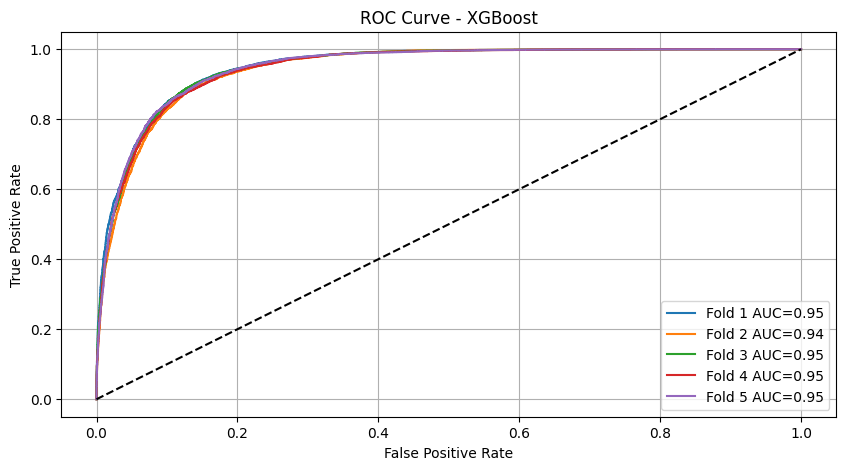

✅ XGBoost model saved.



In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc 
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

# Load data
df = pd.read_csv(r'C:\Users\akhil\OneDrive\Documents\point2building\train.csv')
feature_cols = ['distance', 'planarity_v1', 'height_diff', 'normal_similarity', 'curvature_v2', 'planarity_v2', 'curvature_v1']
X = df[feature_cols].values
y = df['label'].values

# Normalize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))
xgb_weight = class_weight_dict[1] / class_weight_dict[0]

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_metrics = {'acc': [], 'prec': [], 'rec': [], 'f1': [], 'fpr': [], 'tpr': [], 'auc': []}

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5,
                                  scale_pos_weight=xgb_weight, use_label_encoder=False,
                                  eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    y_proba = xgb_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > 0.5).astype(int)

    xgb_metrics['acc'].append(accuracy_score(y_test, y_pred))
    xgb_metrics['prec'].append(precision_score(y_test, y_pred))
    xgb_metrics['rec'].append(recall_score(y_test, y_pred))
    xgb_metrics['f1'].append(f1_score(y_test, y_pred))
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    xgb_metrics['fpr'].append(fpr)
    xgb_metrics['tpr'].append(tpr)
    xgb_metrics['auc'].append(auc(fpr, tpr))

# Print metrics
print("\n📊 XGBoost (5-Fold CV):")
print(f"Accuracy:  {np.mean(xgb_metrics['acc']):.4f}")
print(f"Precision: {np.mean(xgb_metrics['prec']):.4f}")
print(f"Recall:    {np.mean(xgb_metrics['rec']):.4f}")
print(f"F1 Score:  {np.mean(xgb_metrics['f1']):.4f}")
print(f"Avg AUC:   {np.mean(xgb_metrics['auc']):.4f}")

# Plot ROC
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(xgb_metrics['fpr'][i], xgb_metrics['tpr'][i], label=f'Fold {i+1} AUC={xgb_metrics["auc"][i]:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


# Save model
final_xgb = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5,
                              scale_pos_weight=xgb_weight, use_label_encoder=False,
                              eval_metric='logloss')
final_xgb.fit(X, y)
joblib.dump(final_xgb, 'xgboost_edge_detector.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(feature_cols, 'feature_columns.pkl')
print("✅ XGBoost model saved.\n")



📊 Random Forest (5-Fold CV):
Accuracy:  0.8922
Precision: 0.8671
Recall:    0.9009
F1 Score:  0.8837
Avg AUC:   0.9582


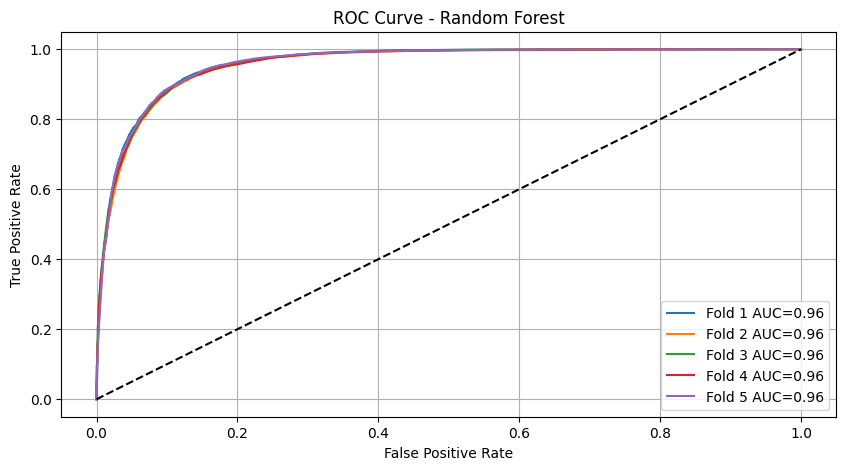

✅ Random Forest model saved.



In [4]:
from sklearn.ensemble import RandomForestClassifier

rf_metrics = {'acc': [], 'prec': [], 'rec': [], 'f1': [], 'fpr': [], 'tpr': [], 'auc': []}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf_model = RandomForestClassifier(n_estimators=100, class_weight=class_weight_dict)
    rf_model.fit(X_train, y_train)
    y_proba = rf_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > 0.5).astype(int)

    rf_metrics['acc'].append(accuracy_score(y_test, y_pred))
    rf_metrics['prec'].append(precision_score(y_test, y_pred))
    rf_metrics['rec'].append(recall_score(y_test, y_pred))
    rf_metrics['f1'].append(f1_score(y_test, y_pred))
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    rf_metrics['fpr'].append(fpr)
    rf_metrics['tpr'].append(tpr)
    rf_metrics['auc'].append(auc(fpr, tpr))

print("\n📊 Random Forest (5-Fold CV):")
print(f"Accuracy:  {np.mean(rf_metrics['acc']):.4f}")
print(f"Precision: {np.mean(rf_metrics['prec']):.4f}")
print(f"Recall:    {np.mean(rf_metrics['rec']):.4f}")
print(f"F1 Score:  {np.mean(rf_metrics['f1']):.4f}")
print(f"Avg AUC:   {np.mean(rf_metrics['auc']):.4f}")

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(rf_metrics['fpr'][i], rf_metrics['tpr'][i], label=f'Fold {i+1} AUC={rf_metrics["auc"][i]:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Save model
final_rf = RandomForestClassifier(n_estimators=100, class_weight=class_weight_dict)
final_rf.fit(X, y)
joblib.dump(final_rf, 'rf_edge_detector.pkl')
print("✅ Random Forest model saved.\n")


In [ ]:
from sklearn.svm import SVC

# Reuse X, y, scaler, class_weight_dict from previous snippet if in same session

svm_metrics = {'acc': [], 'prec': [], 'rec': [], 'f1': [], 'fpr': [], 'tpr': [], 'auc': []}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    svm_model = SVC(kernel='rbf', probability=True, class_weight=class_weight_dict)
    svm_model.fit(X_train, y_train)
    y_proba = svm_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > 0.5).astype(int)

    svm_metrics['acc'].append(accuracy_score(y_test, y_pred))
    svm_metrics['prec'].append(precision_score(y_test, y_pred))
    svm_metrics['rec'].append(recall_score(y_test, y_pred))
    svm_metrics['f1'].append(f1_score(y_test, y_pred))
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    svm_metrics['fpr'].append(fpr)
    svm_metrics['tpr'].append(tpr)
    svm_metrics['auc'].append(auc(fpr, tpr))

print("\n📊 SVM (5-Fold CV):")
print(f"Accuracy:  {np.mean(svm_metrics['acc']):.4f}")
print(f"Precision: {np.mean(svm_metrics['prec']):.4f}")
print(f"Recall:    {np.mean(svm_metrics['rec']):.4f}")
print(f"F1 Score:  {np.mean(svm_metrics['f1']):.4f}")
print(f"Avg AUC:   {np.mean(svm_metrics['auc']):.4f}")

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(svm_metrics['fpr'][i], svm_metrics['tpr'][i], label=f'Fold {i+1} AUC={svm_metrics["auc"][i]:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Save model
final_svm = SVC(kernel='rbf', probability=True, class_weight=class_weight_dict)
final_svm.fit(X, y)
joblib.dump(final_svm, 'svm_edge_detector.pkl')
print("✅ SVM model saved.\n")


In [2]:
! pip install lightgbm catboost


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 162.9 kB/s eta 0:00:06
   -------------- ------------------------- 0.5/1.5 MB 162.9 kB/s eta 0:00:06
   -------------- ------------------------- 0.5/1.5 MB 162.9 kB/s eta 0:00:06
   ----


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\akhil\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


   -------------------------------- ------ 84.7/101.7 MB 601.7 kB/s eta 0:00:29
   -------------------------------- ------ 84.7/101.7 MB 601.7 kB/s eta 0:00:29
   -------------------------------- ------ 84.9/101.7 MB 594.2 kB/s eta 0:00:29
   -------------------------------- ------ 84.9/101.7 MB 594.2 kB/s eta 0:00:29
   -------------------------------- ------ 84.9/101.7 MB 594.2 kB/s eta 0:00:29
   -------------------------------- ------ 84.9/101.7 MB 594.2 kB/s eta 0:00:29
   -------------------------------- ------ 84.9/101.7 MB 594.2 kB/s eta 0:00:29
   -------------------------------- ------ 84.9/101.7 MB 594.2 kB/s eta 0:00:29
   -------------------------------- ------ 85.2/101.7 MB 571.9 kB/s eta 0:00:29
   -------------------------------- ------ 85.2/101.7 MB 571.9 kB/s eta 0:00:29
   -------------------------------- ------ 85.2/101.7 MB 571.9 kB/s eta 0:00:29
   -------------------------------- ------ 85.5/101.7 MB 576.1 kB/s eta 0:00:29
   -------------------------------- ----

🔄 Training ExtraTrees...
Fold 1 Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     13623
           1       0.79      0.92      0.85     11353

    accuracy                           0.85     24976
   macro avg       0.85      0.85      0.85     24976
weighted avg       0.86      0.85      0.85     24976

Fold 2 Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86     13623
           1       0.81      0.89      0.85     11352

    accuracy                           0.86     24975
   macro avg       0.86      0.86      0.86     24975
weighted avg       0.86      0.86      0.86     24975

Fold 3 Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     13623
           1       0.81      0.91      0.85     11352

    accuracy                           0.86     24975
   macro avg       0.86      0.86      0.86     24975
weig

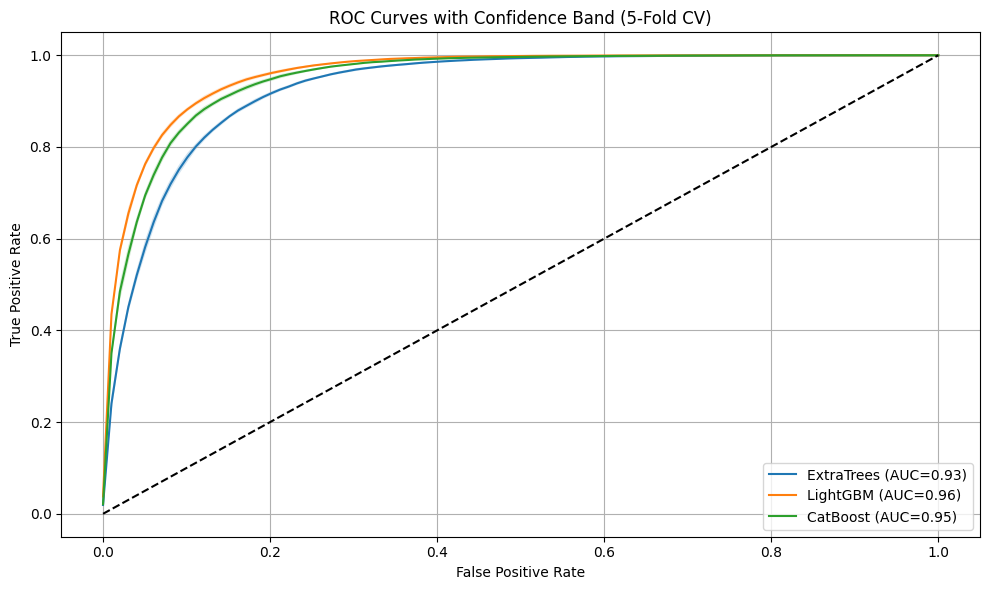

✅ Model saved: extratrees_edge_detector.pkl
[LightGBM] [Info] Number of positive: 56762, number of negative: 68114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 124876, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
✅ Model saved: lightgbm_edge_detector.pkl
✅ Model saved: catboost_edge_detector.pkl


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve,
    auc, classification_report
)
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from catboost import CatBoostClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")

# Load Data
df = pd.read_csv(r"C:\Users\akhil\OneDrive\Documents\point2building\RoofVE-main\balanced_dataset.csv")
X = df.drop(columns=["label"]).values
y = df["label"].values

# Feature Scaling (optional for tree models but helps sometimes)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Model configs
models = {
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=200, max_depth=15, class_weight="balanced", random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMClassifier(
        num_leaves=31, n_estimators=200, class_weight="balanced", random_state=42),
    "CatBoost": CatBoostClassifier(
        iterations=300, depth=6, learning_rate=0.05, verbose=0,
        class_weights=[1, sum(y == 0) / sum(y == 1)])
}

# Initialize cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {name: {"acc": [], "prec": [], "rec": [], "f1": [], "auc": [], "thresholds": []} for name in models}
roc_data = {}

# Cross-validation loop
for name, model in models.items():
    print(f"🔄 Training {name}...")
    fprs, tprs = [], []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_scaled, y)):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Dynamic thresholding using F1
        from sklearn.metrics import precision_recall_curve
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
        best_idx = np.argmax(f1_scores)
        best_thresh = thresholds[best_idx]
        results[name]["thresholds"].append(best_thresh)
        y_pred = (y_proba > best_thresh).astype(int)

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results[name]["acc"].append(acc)
        results[name]["prec"].append(prec)
        results[name]["rec"].append(rec)
        results[name]["f1"].append(f1)

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        fprs.append(fpr)
        tprs.append(tpr)
        try:
            results[name]["auc"].append(auc(fpr, tpr))
        except:
            results[name]["auc"].append(0)

        print(f"Fold {fold+1} Report:\n{classification_report(y_test, y_pred)}")

    roc_data[name] = (fprs, tprs)

# Summary report
for name in models:
    print(f"\n📊 {name} (5-Fold CV):")
    print(f"Accuracy:  {np.mean(results[name]['acc']):.4f}")
    print(f"Precision: {np.mean(results[name]['prec']):.4f}")
    print(f"Recall:    {np.mean(results[name]['rec']):.4f}")
    print(f"F1 Score:  {np.mean(results[name]['f1']):.4f}")
    print(f"Avg AUC:   {np.mean(results[name]['auc']):.4f}")
    print(f"Best Threshold (avg): {np.mean(results[name]['thresholds']):.4f}")

# Plot ROC Curves with Confidence Bands
plt.figure(figsize=(10, 6))
for name in roc_data:
    fprs, tprs = roc_data[name]
    mean_fpr = np.linspace(0, 1, 100)
    interp_tprs = [np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fprs, tprs)]
    mean_tpr = np.mean(interp_tprs, axis=0)
    std_tpr = np.std(interp_tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, label=f"{name} (AUC={mean_auc:.2f})")
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=0.2)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves with Confidence Band (5-Fold CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save final trained models
for name, model in models.items():
    model.fit(X_scaled, y)
    joblib.dump(model, f"{name.lower()}_edge_detector.pkl")
    print(f"✅ Model saved: {name.lower()}_edge_detector.pkl")




🔄 Training ExtraTrees...


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]



🔄 Training LightGBM...


  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 36328, number of negative: 43592
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 79920, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


 20%|██        | 1/5 [00:00<00:03,  1.17it/s]

[LightGBM] [Info] Number of positive: 36327, number of negative: 43593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 79920, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


 40%|████      | 2/5 [00:01<00:02,  1.37it/s]

[LightGBM] [Info] Number of positive: 36327, number of negative: 43593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 79920, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


 60%|██████    | 3/5 [00:02<00:01,  1.35it/s]

[LightGBM] [Info] Number of positive: 36327, number of negative: 43593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 79920, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


 80%|████████  | 4/5 [00:02<00:00,  1.34it/s]

[LightGBM] [Info] Number of positive: 36327, number of negative: 43593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 79920, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]



🔄 Training CatBoost...


100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


📊 EXTRATREES - 5 Fold Cross Validation:
Accuracy:  0.8577
Precision: 0.8210
Recall:    0.8787
F1 Score:  0.8488
Avg AUC:   0.9304
🔧 Best Threshold (mean): 0.54

📊 LIGHTGBM - 5 Fold Cross Validation:
Accuracy:  0.8921
Precision: 0.8741
Recall:    0.8911
F1 Score:  0.8824
Avg AUC:   0.9593
🔧 Best Threshold (mean): 0.59

📊 CATBOOST - 5 Fold Cross Validation:
Accuracy:  0.8810
Precision: 0.8533
Recall:    0.8915
F1 Score:  0.8720
Avg AUC:   0.9491
🔧 Best Threshold (mean): 0.56


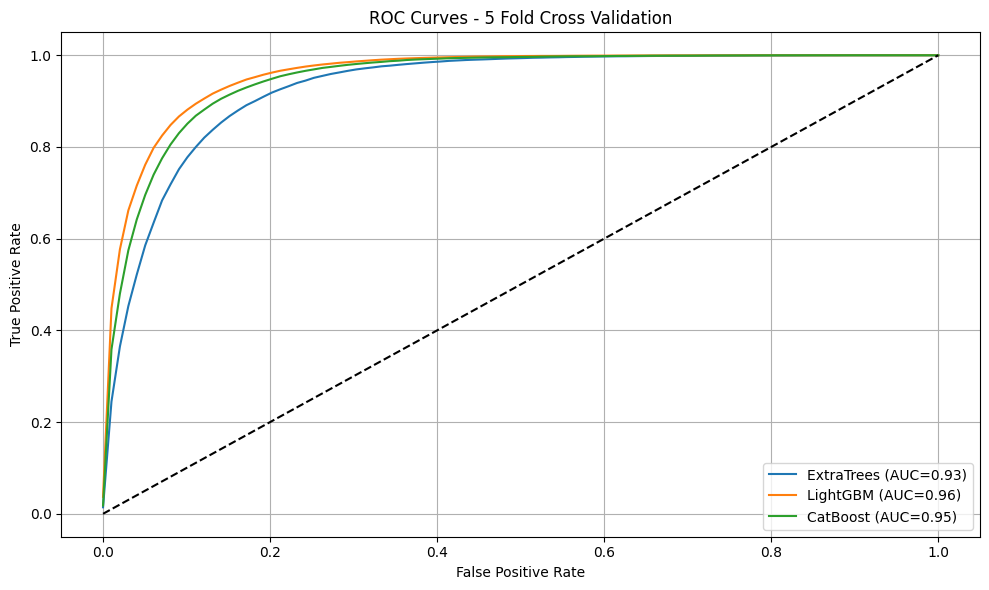

✅ Saved: extratrees_edge_detector.pkl
[LightGBM] [Info] Number of positive: 45409, number of negative: 54491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 99900, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
✅ Saved: lightgbm_edge_detector.pkl
✅ Saved: catboost_edge_detector.pkl


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix
)
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import joblib
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# =====================
# Load Data
# =====================
df = pd.read_csv(r"C:\Users\akhil\OneDrive\Documents\point2building\train.csv")
X = df.drop(columns=["label"]).values
y = df["label"].values

# =====================
# Model Definitions
# =====================
models = {
    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=200, max_depth=15, class_weight="balanced", random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMClassifier(
        num_leaves=31, n_estimators=200, class_weight="balanced", random_state=42),
    "CatBoost": CatBoostClassifier(
        iterations=300, depth=6, learning_rate=0.05, verbose=0,
        class_weights=[1, sum(y == 0) / sum(y == 1)])
}

# =====================
# Cross Validation
# =====================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {name: {
    "acc": [], "prec": [], "rec": [], "f1": [], "auc": [],
    "fpr": [], "tpr": [], "thresholds": []
} for name in models}

# =====================
# Training Loop
# =====================
for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    for fold, (train_idx, test_idx) in enumerate(tqdm(skf.split(X, y), total=5)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Find best threshold for highest accuracy
        thresholds = np.linspace(0, 1, 200)
        accs = [accuracy_score(y_test, (y_proba > t).astype(int)) for t in thresholds]
        best_thresh = thresholds[np.argmax(accs)]
        results[name]["thresholds"].append(best_thresh)

        y_pred = (y_proba > best_thresh).astype(int)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results[name]["acc"].append(acc)
        results[name]["prec"].append(prec)
        results[name]["rec"].append(rec)
        results[name]["f1"].append(f1)

        try:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            results[name]["fpr"].append(fpr)
            results[name]["tpr"].append(tpr)
            results[name]["auc"].append(roc_auc)
        except:
            print(f"⚠️ ROC undefined for {name} in fold {fold}")

# =====================
# Summary Metrics
# =====================
for name in models:
    print(f"\n📊 {name.upper()} - 5 Fold Cross Validation:")
    print(f"Accuracy:  {np.mean(results[name]['acc']):.4f}")
    print(f"Precision: {np.mean(results[name]['prec']):.4f}")
    print(f"Recall:    {np.mean(results[name]['rec']):.4f}")
    print(f"F1 Score:  {np.mean(results[name]['f1']):.4f}")
    if results[name]["auc"]:
        print(f"Avg AUC:   {np.mean(results[name]['auc']):.4f}")
    print(f"🔧 Best Threshold (mean): {np.mean(results[name]['thresholds']):.2f}")

# =====================
# ROC Curve Plot
# =====================
plt.figure(figsize=(10, 6))
for name in models:
    if not results[name]["tpr"]:
        continue
    mean_fpr = np.linspace(0, 1, 100)
    tprs = [np.interp(mean_fpr, results[name]["fpr"][i], results[name]["tpr"][i])
            for i in range(len(results[name]["tpr"]))]
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label=f"{name} (AUC={mean_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - 5 Fold Cross Validation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================
# Save Final Models
# =====================
for name, model in models.items():
    model.fit(X, y)
    joblib.dump(model, f"{name.lower()}_edge_detector.pkl")
    print(f"✅ Saved: {name.lower()}_edge_detector.pkl")



In [11]:
import joblib

# Example:
joblib.dump(lgb_model, 'lightgbm_model.pkl')
joblib.dump(cat_model, 'catboost_model.pkl')
joblib.dump(et_model, 'extratrees_model.pkl')


['extratrees_model.pkl']

In [ ]:
########### testing ########


📊 Test Set Evaluation:
Accuracy:  0.8732
Precision: 0.8317
Recall:    0.9040
F1 Score:  0.8663


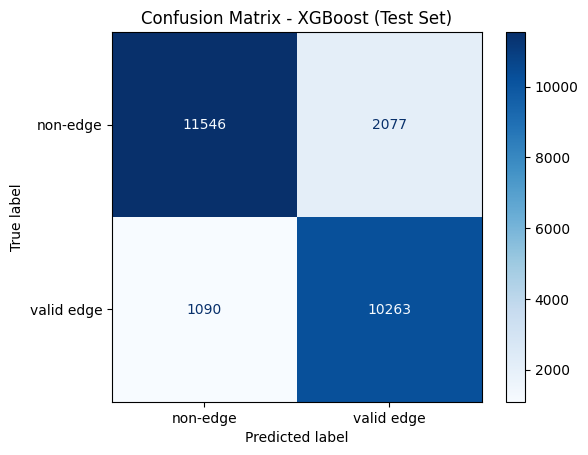

In [14]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Optional: Disable scientific notation globally for plots
plt.rcParams['axes.formatter.useoffset'] = False

# Load saved model, scaler and feature columns
model = joblib.load('xgboost_edge_detector.pkl')
scaler = joblib.load('scaler.pkl')
feature_cols = joblib.load('feature_columns.pkl')

# Load test dataset
test_df = pd.read_csv(r'C:\Users\akhil\OneDrive\Documents\point2building\test.csv')  # ⬅️ Adjust path as needed
X_test = test_df[feature_cols].values
y_test = test_df['label'].values

# Normalize using the training scaler
X_test_scaled = scaler.transform(X_test)

# Predict
y_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba > 0.5).astype(int)

# Compute metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print("\n📊 Test Set Evaluation:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-edge", "valid edge"])
disp.plot(cmap='Blues', values_format='d')  # <- integer formatting to avoid scientific notation
plt.title("Confusion Matrix - XGBoost (Test Set)")
plt.grid(False)
plt.show()




🌲 Random Forest - Test Set Evaluation:
Accuracy:  0.8932
Precision: 0.8717
Recall:    0.8971
F1 Score:  0.8842


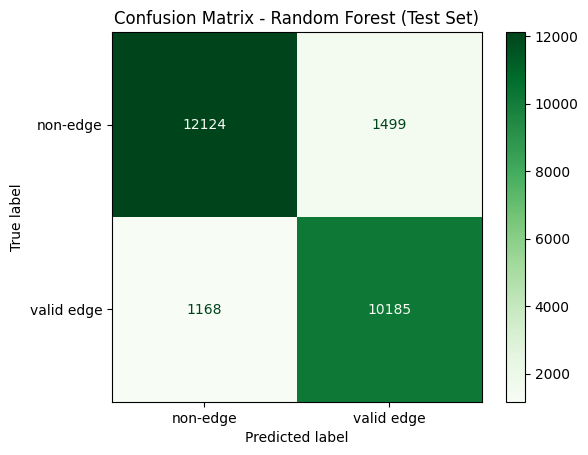

In [15]:
# Load saved RF model
rf_model = joblib.load('rf_edge_detector.pkl')

# Predict
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
y_pred_rf = (y_proba_rf > 0.51).astype(int)

# Compute metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Print metrics
print("\n🌲 Random Forest - Test Set Evaluation:")
print(f"Accuracy:  {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall:    {rec_rf:.4f}")
print(f"F1 Score:  {f1_rf:.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["non-edge", "valid edge"])
disp_rf.plot(cmap='Greens', values_format='d')  # ✅ disables scientific notation
plt.title("Confusion Matrix - Random Forest (Test Set)")
plt.grid(False)
plt.show()


In [ ]:
# Load saved SVM model
svm_model = joblib.load('svm_edge_detector.pkl')

# Predict
y_pred_svm = svm_model.predict(X_test_scaled)  # SVM may not have predict_proba unless you used `probability=True`

# Compute metrics
acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm)
rec_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

# Print metrics
print("\n💠 SVM - Test Set Evaluation:")
print(f"Accuracy:  {acc_svm:.4f}")
print(f"Precision: {prec_svm:.4f}")
print(f"Recall:    {rec_svm:.4f}")
print(f"F1 Score:  {f1_svm:.4f}")

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["Class 0", "Class 1"])
disp_svm.plot(cmap='Purples')
plt.title("Confusion Matrix - SVM (Test Set)")
plt.grid(False)
plt.show()


🔧 Best Threshold: 0.52

📊 EXTRATREES - Test Set Evaluation:
Accuracy:  0.8543
Precision: 0.8032
Recall:    0.8999
F1 Score:  0.8488


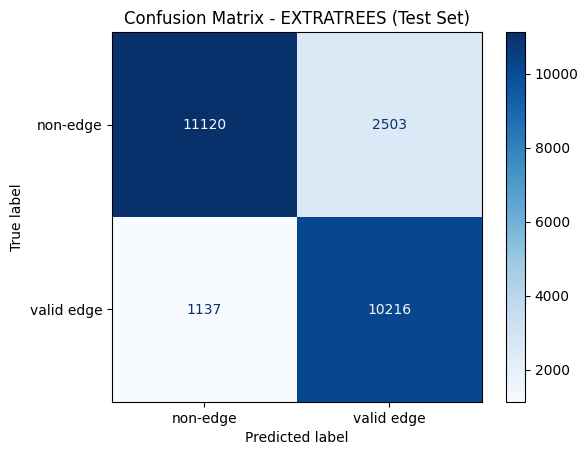

🔧 Best Threshold: 0.53

📊 LIGHTGBM - Test Set Evaluation:
Accuracy:  0.8938
Precision: 0.8616
Recall:    0.9131
F1 Score:  0.8866


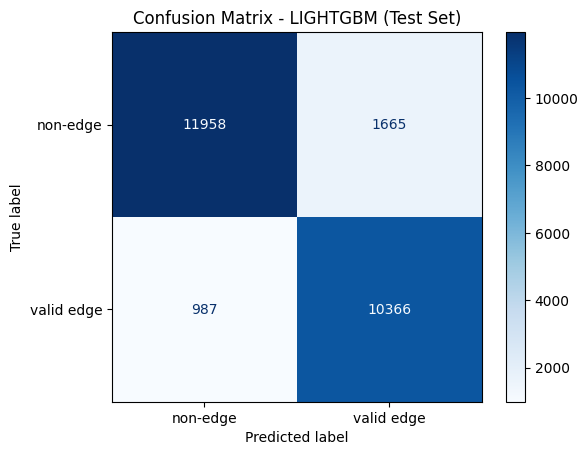

🔧 Best Threshold: 0.51

📊 CATBOOST - Test Set Evaluation:
Accuracy:  0.8776
Precision: 0.8369
Recall:    0.9077
F1 Score:  0.8709


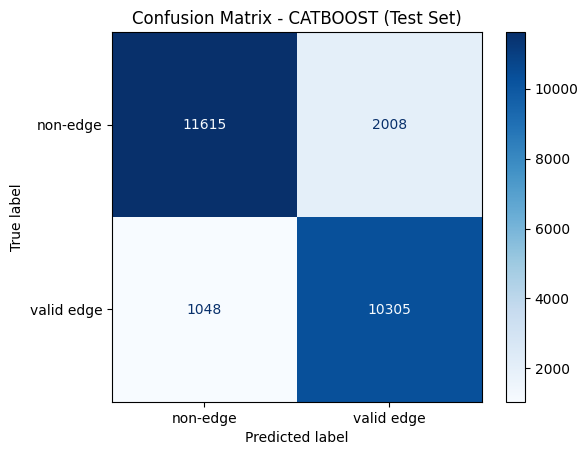

In [13]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
)
import matplotlib.pyplot as plt

# Disable scientific notation globally
plt.rcParams['axes.formatter.useoffset'] = False

# Load test dataset
test_df = pd.read_csv(r'C:\Users\akhil\OneDrive\Documents\point2building\test.csv')
X_test = test_df.drop(columns=["label"]).values
y_test = test_df["label"].values

# Load each model and evaluate
for model_name in ["extratrees", "lightgbm", "catboost"]:
    try:
        model = joblib.load(f"{model_name}_edge_detector.pkl")
        y_proba = model.predict_proba(X_test)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]

        print(f"🔧 Best Threshold: {best_threshold:.2f}")
        y_pred = (y_proba > best_threshold).astype(int)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"\n📊 {model_name.upper()} - Test Set Evaluation:")
        print(f"Accuracy:  {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"F1 Score:  {f1:.4f}")

        # Plot confusion matrix without scientific notation
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-edge", "valid edge"])
        disp.plot(cmap="Blues", values_format='d')  # <- integer formatting
        plt.title(f"Confusion Matrix - {model_name.upper()} (Test Set)")
        plt.grid(False)
        plt.show()

    except Exception as e:
        print(f"⚠️ Could not evaluate {model_name.upper()}: {e}")




In [11]:
import open3d as o3d
import pandas as pd
import numpy as np
import joblib
import os

# === Load models and scaler ===
xgb_model = joblib.load('xgboost_edge_detector.pkl')
rf_model = joblib.load('rf_edge_detector.pkl')
svm_model = joblib.load('svm_edge_detector.pkl')
scaler = joblib.load('scaler.pkl')
feature_cols = joblib.load('feature_columns.pkl')  # list of feature names

# === Load .obj file ===
def load_obj_file(file_path):
    vertices = []
    edges = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('v '):
                parts = list(map(float, line.strip().split()[1:]))
                vertices.append(parts)
            elif line.startswith('l '):
                indices = list(map(int, line.strip().split()[1:]))
                edges.append((indices[0]-1, indices[1]-1))  # OBJ is 1-indexed
    return np.array(vertices), edges

# === Predict and visualize ===
def predict_and_visualize_from_csv(obj_path, csv_path):
    # Load vertices and GT edges
    vertices, gt_edges = load_obj_file(obj_path)

    # Load features from CSV
    df = pd.read_csv(csv_path)
    edge_indices = df[['v1', 'v2']].values.astype(int)  # <== updated here
    X_features = df[feature_cols].values

    # Scale
    X_scaled = scaler.transform(X_features)

    # Predict
    proba_xgb = xgb_model.predict_proba(X_scaled)[:, 1]
    proba_rf = rf_model.predict_proba(X_scaled)[:, 1]
    pred_svm = svm_model.predict(X_scaled)

    threshold = 0.5
    pred_edges_xgb = [tuple(e) for e, p in zip(edge_indices, proba_xgb) if p > threshold]
    pred_edges_rf = [tuple(e) for e, p in zip(edge_indices, proba_rf) if p > threshold]
    pred_edges_svm = [tuple(e) for e, p in zip(edge_indices, pred_svm) if p == 1]

    # Visuals
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(vertices)

    def make_lineset(edges, color):
        lineset = o3d.geometry.LineSet()
        lineset.points = o3d.utility.Vector3dVector(vertices)
        lineset.lines = o3d.utility.Vector2iVector(edges)
        lineset.colors = o3d.utility.Vector3dVector([color] * len(edges))
        return lineset

    # Create visual linesets
    linesets = [
        make_lineset(gt_edges, [0, 1, 0]),         # Green = GT
        make_lineset(pred_edges_xgb, [1, 0, 0]),   # Red = XGBoost
        make_lineset(pred_edges_rf, [0, 0, 1]),    # Blue = RF
        make_lineset(pred_edges_svm, [1, 0, 1]),   # Magenta = SVM
    ]

    print("✅ Visualizing: Green=GT, Red=XGBoost, Blue=RF, Magenta=SVM")
    o3d.visualization.draw_geometries([pcd] + linesets)

# === Run it ===
obj_file = r'C:\Users\akhil\OneDrive\Documents\point2building\RoofVE-main\wireframe\10068.obj'
csv_file = r'C:\Users\akhil\OneDrive\Documents\point2building\test_data_features.csv'
predict_and_visualize_from_csv(obj_file, csv_file)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
✅ Visualizing: Green=GT, Red=XGBoost, Blue=RF, Magenta=SVM
